In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

# Load Dataset

In [2]:
user_table = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/Pricing_Test/user_table.csv')
user_table.head(10)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68
5,229234,New York,USA,40.67,-73.94
6,339138,Durham,USA,35.98,-78.91
7,270353,New York,USA,40.67,-73.94
8,166748,Burke,USA,38.78,-77.27
9,167700,New York,USA,40.67,-73.94


In [3]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [5]:
user_table.isnull().sum()
## no missing data in the user table

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [6]:
test_results = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/Pricing_Test/test_results.csv',parse_dates=['timestamp'])
test_results.head(10)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0


In [7]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [9]:
test_results.isnull().sum()
## no missing data in test result table

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

# Data Processing and Cleaning

## check data uniqueness

In [10]:
print(len(test_results) == test_results['user_id'].nunique())

True


In [11]:
print(len(user_table) == user_table['user_id'].nunique())

True


In [12]:
## both table have unique user id

## Merge two dataset together

In [13]:
data = pd.merge(left = test_results, right = user_table, how = 'left', on='user_id')
data.head(10)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,New York,USA,40.67,-73.94
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47


## Test and control crosscheck

In [15]:
data[['price','test','user_id']].groupby(['test','price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [16]:
## there should be 66% $39 belong 0, and 33% $59 belong 1. However, there are 210 units
## with price 59 but belongs to 0, and 155 units with price 39 but belongs to 1.

In [17]:
## remove invalid data
data = data[((data['test']==0)&(data['price']==39))|((data['test']==1)&(data['price']==59))]

## Create revenue column to record actual purchase (convert)

In [19]:
data['revenue']=data['converted']*data['price']

In [20]:
data.head(10)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,New York,USA,40.67,-73.94,0
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN,0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21,59
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20,0
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47,0


In [21]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

# Exploratory data analysis (visualization)

## Source

In [23]:
data['source'].value_counts(normalize=True)

direct_traffic     0.190472
ads-google         0.187533
ads_facebook       0.168613
ads_other          0.094256
seo-google         0.073152
ads-bing           0.072151
seo_facebook       0.066943
friend_referral    0.065347
seo-other          0.029213
ads-yahoo          0.023926
seo-yahoo          0.021619
seo-bing           0.006775
Name: source, dtype: float64

In [36]:
tmp = data.groupby('test')['source'].value_counts(normalize=True).unstack()

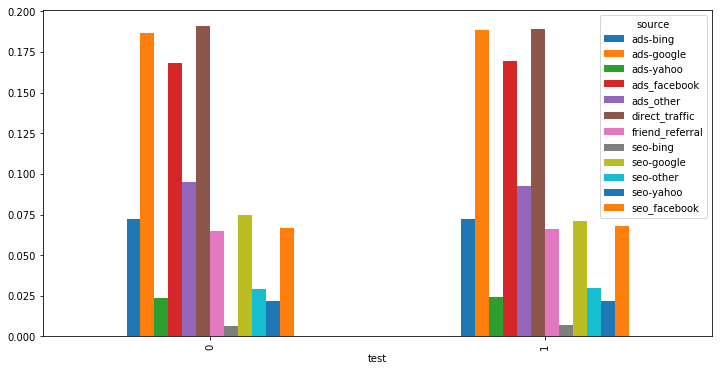

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

In [41]:
count = data[['source', 'test', 'revenue']].groupby(['source', 'test']).count().reset_index()

In [44]:
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / len(data[data['test']==1])

In [46]:
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue']/len(data[data['test']==0]) 

In [47]:
count

,source,test,revenue
0,ads-bing,0,0.072014
1,ads-bing,1,0.072394
2,ads-google,0,0.186873
3,ads-google,1,0.188706
4,ads-yahoo,0,0.023761
5,ads-yahoo,1,0.024219
6,ads_facebook,0,0.168253
7,ads_facebook,1,0.169253
8,ads_other,0,0.095083
9,ads_other,1,0.092786


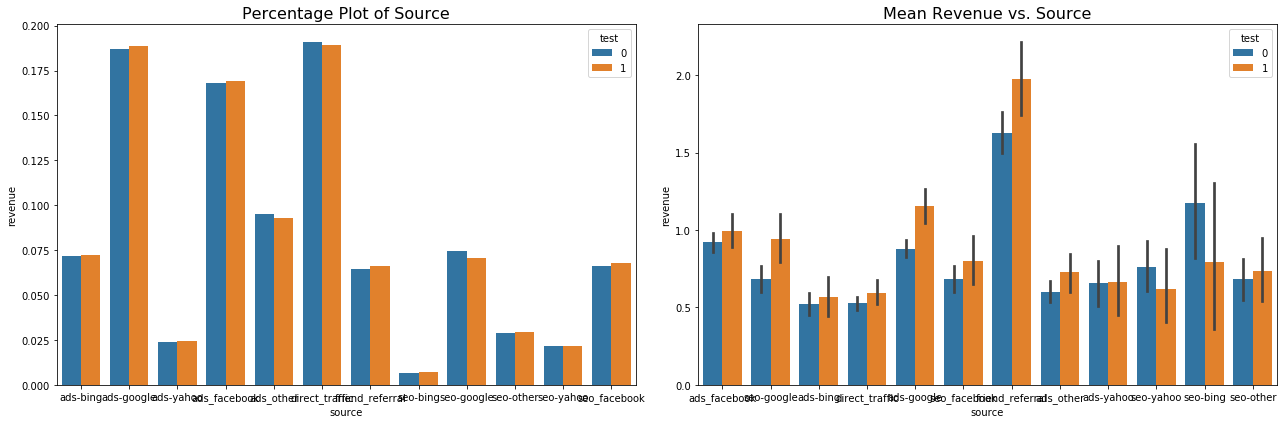

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()


In [49]:
## left chart is percentage count of each source for both test/control. right chart is the mean revenue of each source for both test/control.

## Device

In [50]:
tmp = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


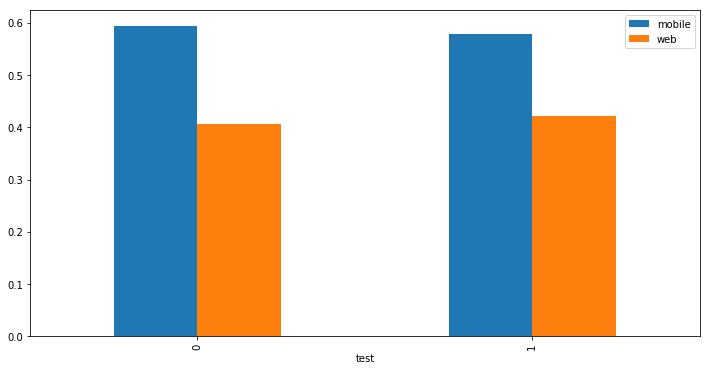

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

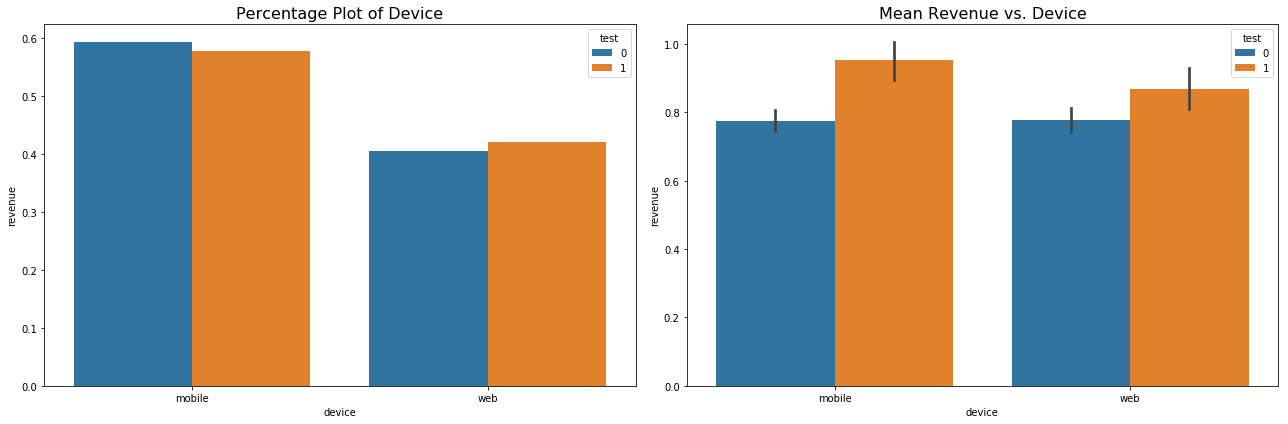

In [52]:
count = data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

## Operating System

In [53]:
tmp = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


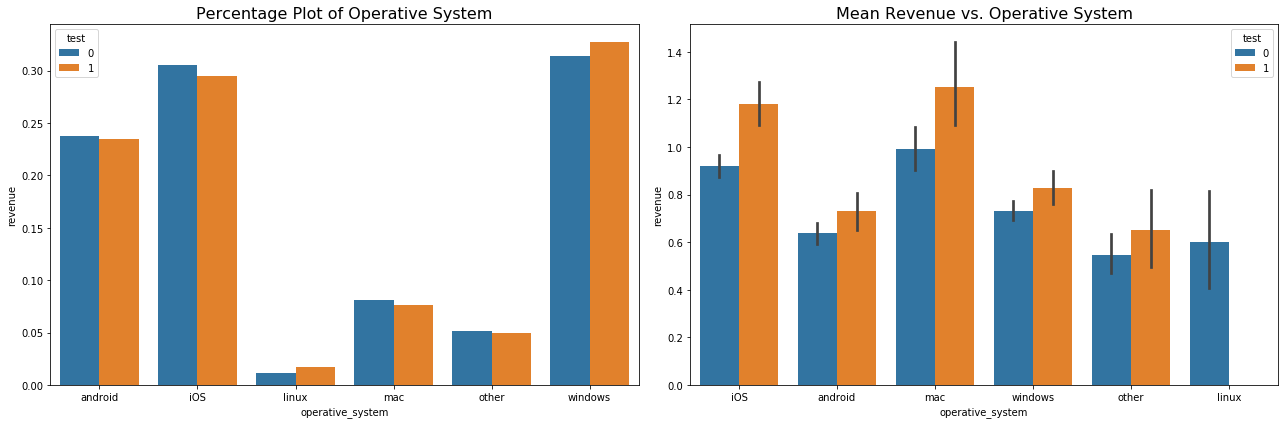

In [54]:
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

In [55]:
## To further check the randomness of experiment across different categorical
## features, we can do the chi square independence test. 

# Question One

In [56]:
## Should the company sell its software for $39 or $59?

In [57]:
## the key point for this question is what metric you wanna choose to determine the strategy?
### two options: 1. conversion rate 2. mean revenue

In [58]:
data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [59]:
# check the revenue for A/B test
data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


In [60]:
## we can see that the conversion rate is dropping, but the overall revenue is up

Now, let's conduct hypothesis testing.

Null hypothesis H0: experimental group's average revenue is equal to or less than control group's average revenue

Alternative hypothesis H1: experimental group's average revenue is higher than control group's average revenue

In [68]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


The above test is actually two tailed test. What we want is one-tailed test. However, from above result, we can easily conclude that even for one-tailed test, we can safely conclude that we can reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.

Although our test suggest that $\$59$ price can give us higher average revenue. However, due to the problem with the A/B test, the above result is not scientifically accurate. More scientific A/B test is needed.

# Question Two

The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

## Source

In [69]:
data.groupby('source')['converted'].mean().reset_index()


,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


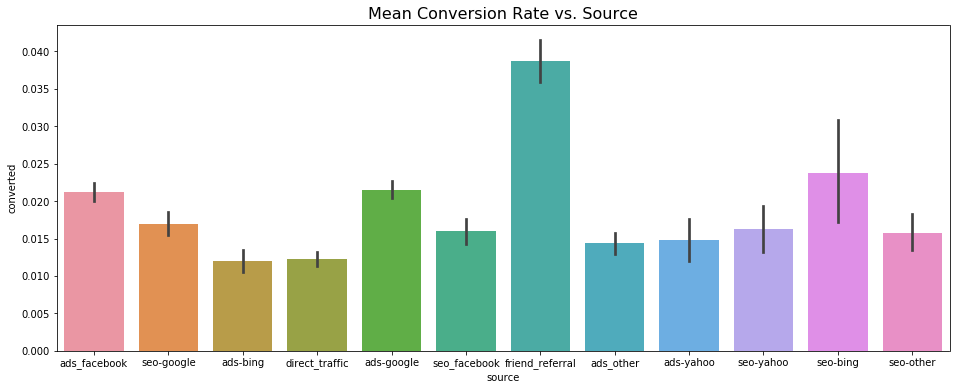

In [70]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

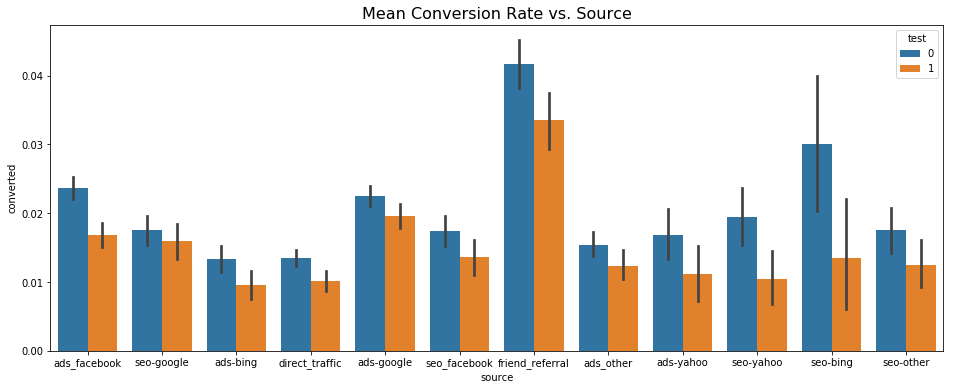

In [71]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

## Device

In [72]:
data.groupby('device')['converted'].mean().reset_index()


,device,converted
0,mobile,0.018554
1,web,0.018023


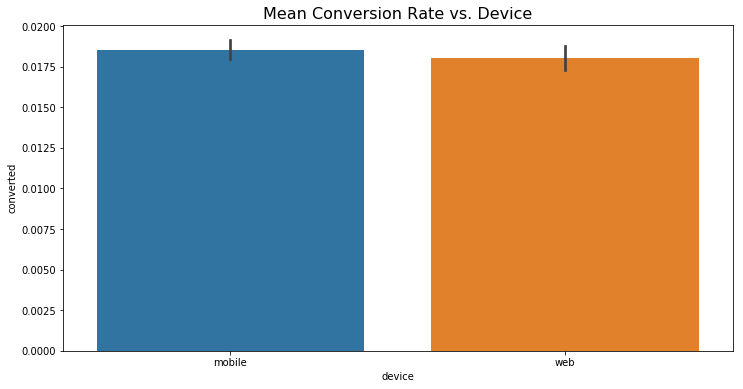

In [73]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

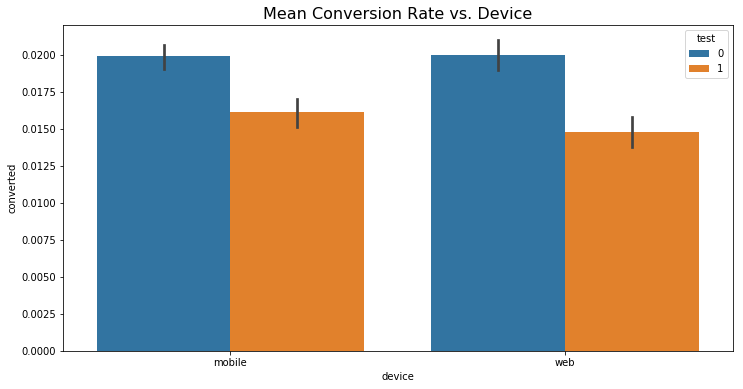

In [74]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

## Operating System

In [75]:
data.groupby('operative_system')['converted'].mean().reset_index()


,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


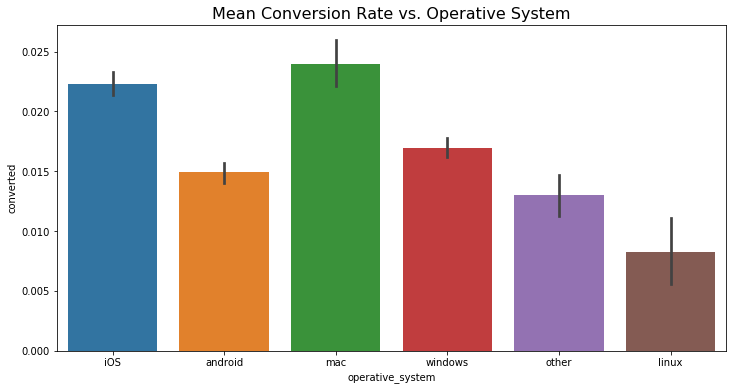

In [76]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

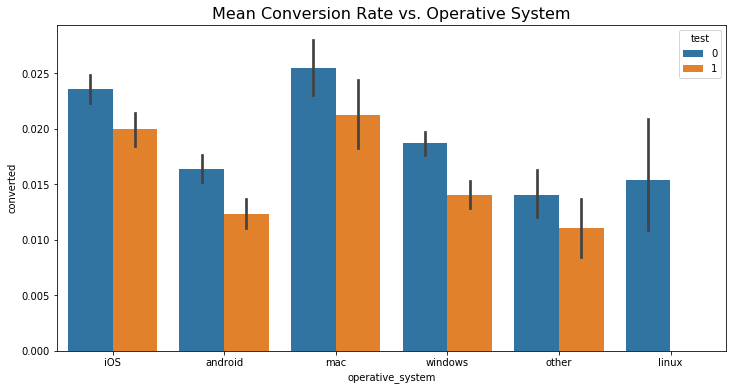

In [77]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

From above visualizations, we can easily conclude that price dramatically influence the conversion rate. But beside price, there are still other factors that can influence the conversion rate.

Source: Friend-referral users have much higher conversion rate

Device: The influence of device is not significant

Operative System: Mac and ios users have much higher conversion rate

Actionable Insights (refer to online resource)
friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors

lauch special marketing program targeted to Apple users (MAC or iOS users)
run some program which rewards user which can invite his/her friend to use our software
Linux users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?

# Question Three

[Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

This problem seems to asking the sample size optimization. Steps should include:
1. calculate required minimum sample size
2. order the data from earliest to latest
3. cutoff at the required sample size
4. run the t-test again to see if the siginificance still holds

## Calculate Required Sample Size

1. the formula: n = 2*sigma^2(Z_(1-beta)+Z_(1-alpha))^2/Diff^2
=> assume Diff = 0.1, 1-beta = .2, 1-alpha = .05
2. Calculate the sigma

In [80]:
from scipy.stats import levene
stat, p = levene(ctr_val, exp_val)

In [81]:
p

5.989596054398887e-10

In [82]:
## the p-value is very small, indicating two groups have different variances.


In [88]:
from scipy.stats import norm

In [93]:
require_size = np.var(data['revenue'].values)*2*((norm.ppf(.2)+norm.ppf(.05))**2)/(.1**2)

In [94]:
require_size

47210.05078502292

In [ ]:
##Assume we need 50000 samples. Based on the preset-proportion, we only need around 17000 test samples, and 33000 control samples.

In [110]:
test_data = data[data['test']==1].sort_values('timestamp').reset_index(drop=True)

In [115]:
test_data1 = test_data.iloc[0:17000, :]

In [118]:
cont_data = data[data['test']==0].sort_values('timestamp').reset_index(drop=True)

In [121]:
cont_data1 = cont_data.iloc[0:33000,:]

In [122]:
ctr_val = cont_data1['revenue'].values
exp_val = test_data1['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-3.271194742180282, pvalue=0.001072320350349201)


In [123]:
max(cont_data1['timestamp'])

'2015-03-17 13:17:58'

In [124]:
max(test_data1['timestamp'])

'2015-03-15 14:10:23'

In [125]:
min(data['timestamp'])

'2015-03-02 00:04:12'

In [126]:
max(data['timestamp'])

'2015-05-31 23:59:45'

Instead of using the total dataset, by calculating the required sample size (50000), we only need to use the data from 3/2 to 3/17, intead of from 3/2 to 5/31.
After cutting the data to the required size, we still achieve the statistical significance with p-value at .001